In [3]:
import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pylab as plt
import statsmodels.api as sm
import warnings
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18, 8
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [4]:
data = pd.read_csv('2013-2014-2015-2016-2017_PM10_Gliwice.csv')
time = 'Czas pomiaru'
pm10_measurement = 'PM10'
data[time] = pd.to_datetime(data[time], errors='coerce', format='%Y-%m-%d %H:%M')
data.index 

data = data.dropna()

data.isnull().sum()

Czas pomiaru    0
PM10            0
dtype: int64

In [5]:
pm10 = data.groupby(time)[pm10_measurement].sum().reset_index()
pm10 = pm10.set_index(time)

pm10_monthly = pm10[pm10_measurement].resample('MS').mean()
pm10_monthly.index
#pm10_monthly.plot(figsize = (15, 6))
#plt.show()

decomposition = sm.tsa.seasonal_decompose(pm10_monthly, model='additive')
#fig = decomposition.plot()
#plt.show()

In [6]:
# ARIMA model
p = d = q = range(0,2)
pdq = list(it.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(it.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(pm10_monthly,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:642.2201596483362
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:486.0100864109701
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:429.1822104406117
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:313.4454042949592
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:435.47831919859766
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:410.40368030518823
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:328.8549494531495
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:313.18052420417774
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:576.8009038262903
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:448.1301279376408
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:421.25458496943315
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:306.42867155676447
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:434.9424311104958
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:400.8977528276801
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:329.88774311554147
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:305.8815049010558
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:506.1357923733837
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:410.7749088493433
ARIM

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2417      0.219      1.102      0.271      -0.188       0.672
ar.S.L12      -0.6357      0.117     -5.433      0.000      -0.865      -0.406
ma.S.L12      -1.0000      0.146     -6.862      0.000      -1.286      -0.714
sigma2       187.1088      0.001    2.4e+05      0.000     187.107     187.110


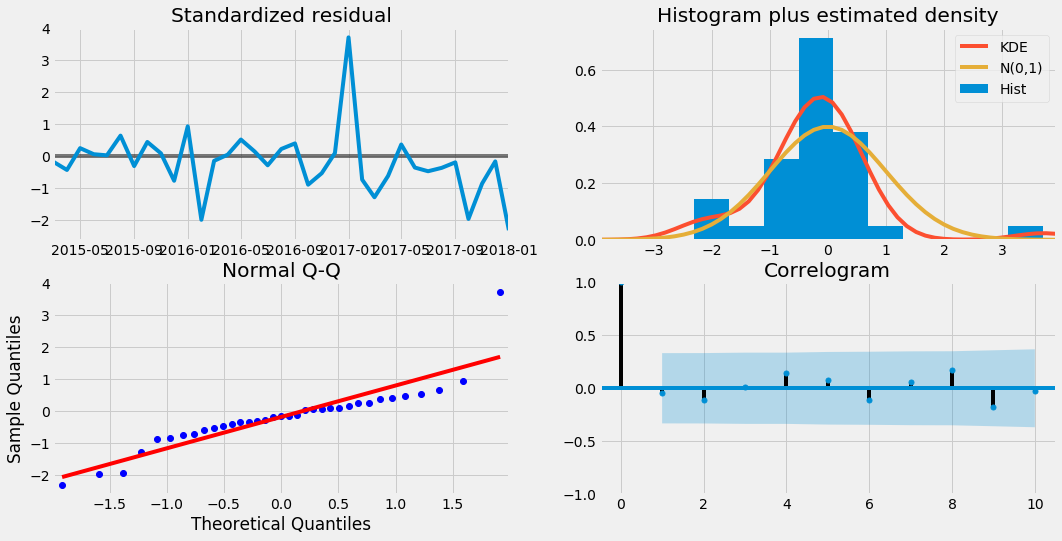

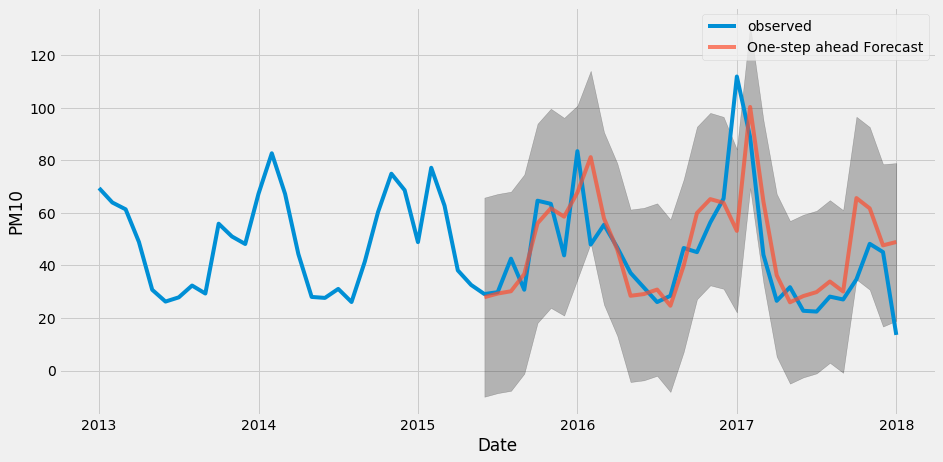

The Mean Squared Error of our forecasts is 511.73
The Root Mean Squared Error of our forecasts is 22.62


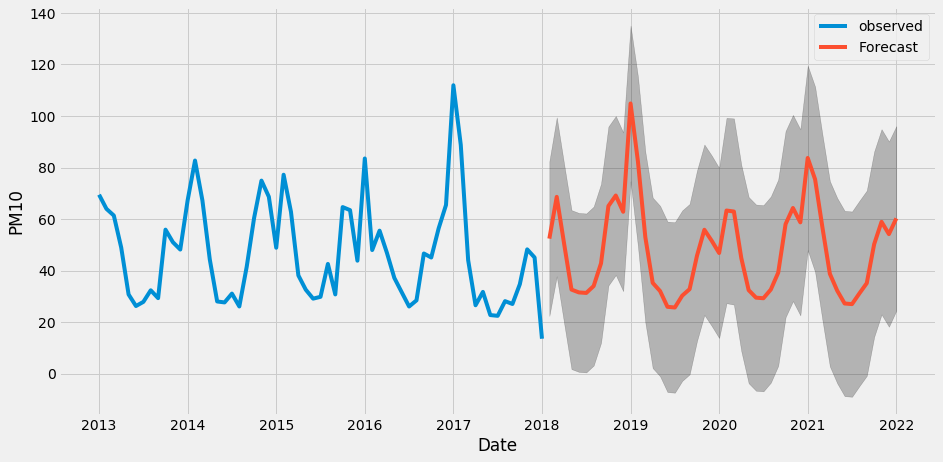

In [7]:
mod = sm.tsa.statespace.SARIMAX(pm10_monthly,
                                order=(0,0,1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(16, 8))
plt.show()

pred = results.get_prediction(start=pd.to_datetime('2015-06-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = pm10_monthly['2013-01-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('PM10')
plt.legend()
plt.show()

pm10_forecasted = pred.predicted_mean
pm10_truth = pm10_monthly['2017-01-01':]

#print(pred)
#print(pm10_forecasted)
#print(pm10_truth)

mse = ((pm10_forecasted - pm10_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

pred_uc = results.get_forecast(steps=48)
pred_ci = pred_uc.conf_int()
ax = pm10_monthly.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('PM10')
plt.legend()
plt.show()

In [8]:
!conda install -c conda-forge fbprophet --yes

Solving environment: done

# All requested packages already installed.



In [9]:
from fbprophet import Prophet

pm10_renamed = data.rename(columns={'Czas pomiaru': 'ds', 'PM10': 'y'})
pm10_renamed = pm10_renamed.groupby('ds')['y'].sum().reset_index()
pm10_renamed = pm10_renamed.set_index('ds')
pm10_renamed = pm10_renamed['y'].resample('MS').mean()
pm10_renamed = pm10_renamed['2015-06-01':]
pm10_renamed = pm10_renamed.reset_index()
pm10_renamed = pd.DataFrame(data = pm10_renamed)


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 24.0.


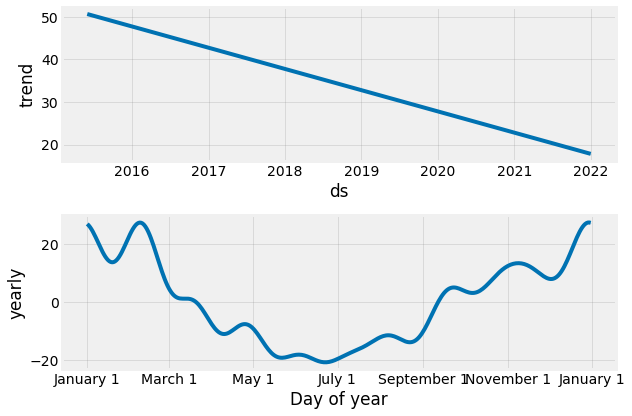

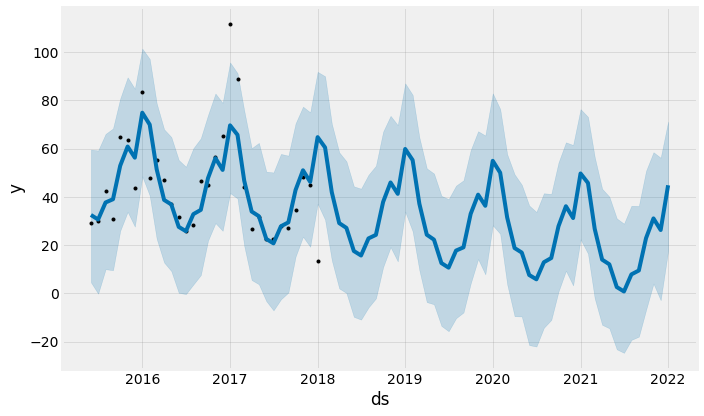

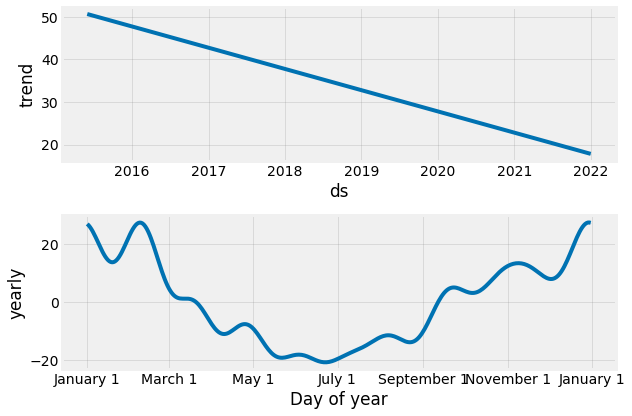

In [10]:
import matplotlib 
pm10_model = Prophet(interval_width=0.95)
pm10_model.fit(pm10_renamed)

future = pm10_model.make_future_dataframe(periods=48, freq='MS')
pm10_forecast = pm10_model.predict(future)

pm10_model.plot(pm10_forecast, uncertainty=True)
pm10_model.plot_components(pm10_forecast)

In [11]:
from fbprophet.diagnostics import performance_metrics
pm10_renamed_length = len(pm10_renamed.index)
print('RMSE: %f' % np.sqrt(np.mean((pm10_forecast.loc[:pm10_renamed_length, 'yhat']-pm10_renamed['y'])**2)) )
print('MSE: %f' % np.mean((pm10_forecast.loc[:pm10_renamed_length, 'yhat']-pm10_renamed['y'])**2))

RMSE: 14.276548
MSE: 203.819827
